In [ ]:
import sys
# Before using tensorflow:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
import tensorflow.keras.backend as KB
from matplotlib import pylab as plt
import tensorflow.keras

import pickle
import numpy as np
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.17.0
Keras Version: 3.4.1

Python 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
GPU is NOT AVAILABLE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Create the model / CNN architecture

In [ ]:
import shutil
import pickle
from pathlib import Path
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tempfile import NamedTemporaryFile

import psutil
learning_rate = 0.001
num_classes=15
decay = 0
class_keys = {'BAS': 0, 'EBO': 1, 'EOS': 2, 'KSC': 3, 'LYA': 4, 'LYT': 5, 'MMZ': 6, 'MOB': 7, 'MON': 8, 'MYB': 9 , 'MYO': 10,
        'NGB': 11, 'NGS': 12, 'PMB': 13, 'PMO': 14}

classes = {'BAS': 'Basophil',
'EBO': 'Erythroblast',
'EOS': 'Eosinophil',
'KSC': 'Smudge cell',
'LYA': 'Lymphocyte (atypical)',
'LYT': 'Lymphocyte (typical)',
'MMZ': 'Metamyelocyte',
'MOB': 'Monoblast',
'MON': 'Monocyte',
'MYB': 'Myelocyte',
'MYO': 'Myeloblast',
'NGB': 'Neutrophil (band)',
'NGS': 'Neutrophil (segmented)',
'PMB': 'Promyelocyte (bilobled)',
'PMO': 'Promyelocyte'}


def construct_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=[100,100,4]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate, decay=decay)

    model.compile(loss='categorical_crossentropy',
                       optimizer=opt,
                       metrics=['accuracy'])

    return model

In [ ]:
import tensorflow
model = construct_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 98, 98, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 98, 98, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 49, 49, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 49, 49, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 47, 47, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 33856)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      17,334,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           7,695 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 15)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,410,383 (66.42 MB)

 Trainable params: 17,409,359 (66.41 MB)

 Non-trainable params: 1,024 (4.00 KB)

## Train a model usign data from one clinic

In [ ]:
import numpy as np
import tensorflow.keras as keras
import os
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, data_path,  batch_size=32, dim=(100,100), n_channels=4,
                 n_classes=15, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.data_path = data_path

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))

        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size,), dtype=int)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load(os.path.join(self.data_path, ID + '.npy'))
            # Store class
            y[i] = self.labels[ID]


        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

    def predict_all(self, model):

        preds = np.empty((len(self.list_IDs), self.n_classes))
        labels = np.empty((len(self.list_IDs), self.n_classes))
        for index in range(self.__len__()):
            indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
            list_IDs_temp = [self.list_IDs[k] for k in indexes]
            X, y = self.__data_generation(list_IDs_temp)
            labels[index*self.batch_size:(index+1)*self.batch_size,] = y
            preds[index*self.batch_size:(index+1)*self.batch_size,] = model.predict(X)

        # extract the last examples
        index = self.__len__()
        indexes = self.indexes[index * self.batch_size:]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        labels[index * self.batch_size:, ] = y[:len(indexes)]
        preds[index * self.batch_size:, ] = model.predict(X[:len(indexes)])

        return labels, preds



In [ ]:
import numpy as np


labels0 = np.load('/content/drive/MyDrive/digital-pathology-tutorial-master/dataset/processed/data_partitions/partition0/labels.npy', allow_pickle=True).item()
data_path0 = '/content/drive/MyDrive/digital-pathology-tutorial-master/dataset/processed/data_partitions/partition0/data_singlets'

ids0 = [l for l in labels0]
np.random.shuffle(ids0)
train_split_index = int(len(ids0)*0.9)
train_ids = ids0[:train_split_index]
val_ids = ids0[train_split_index:]

train_gen = DataGenerator(train_ids,labels0, data_path0, dim=(100,100), batch_size=32)
val_gen = DataGenerator(val_ids,labels0, data_path0, dim=(100,100), batch_size=32)

In [ ]:
model.fit(train_gen,epochs=11)

Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


258/258 ━━━━━━━━━━━━━━━━━━━━ 2227s 8s/step - accuracy: 0.6295 - loss: 1.3457
Epoch 2/11
258/258 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step - accuracy: 0.8329 - loss: 0.5331
Epoch 3/11
258/258 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.8724 - loss: 0.3916
Epoch 4/11
258/258 ━━━━━━━━━━━━━━━━━━━━ 572s 2s/step - accuracy: 0.9037 - loss: 0.3155
Epoch 5/11
258/258 ━━━━━━━━━━━━━━━━━━━━ 619s 2s/step - accuracy: 0.9061 - loss: 0.2883
Epoch 6/11
258/258 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - accuracy: 0.9192 - loss: 0.2400
Epoch 7/11
258/258 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.9291 - loss: 0.2160
Epoch 8/11
258/258 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - accuracy: 0.9472 - loss: 0.1579
Epoch 9/11
258/258 ━━━━━━━━━━━━━━━━━━━━ 615s 2s/step - accuracy: 0.9514 - loss: 0.1554
Epoch 10/11
258/258 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.9552 - loss: 0.1223
Epoch 11/11
258/258 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.9612 - loss: 0.1134


## Model validation - plot a confusion matrix

We reserve partition1 as a validation set

In [ ]:
np.sort([k for k in labels0])

labels1 = np.load('/content/drive/MyDrive/digital-pathology-tutorial-master/dataset/processed/data_partitions/partition1/labels.npy', allow_pickle=True).item()
data_path1 = '/content/drive/MyDrive/digital-pathology-tutorial-master/dataset/processed/data_partitions/partition1/data_singlets'

ids1 = [l for l in labels1]
np.random.shuffle(ids1)

test_gen = DataGenerator(ids1,labels1, data_path1, dim=(100,100), batch_size=32)
labels, preds = test_gen.predict_all(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784

In [ ]:
def confusion_matrix(model, data_gen):

    labels, preds = data_gen.predict_all(model)

    y_pred = np.argmax(preds,1)
    y_data = np.argmax(labels,1)
    M = np.zeros((16,16))

    for pred_, true_ in zip(y_pred,y_data):
        M[true_,pred_] +=1

    M[15,:15] = np.sum(M[:15,:15],0)
    M[:15,15] = np.sum(M[:15,:15],1)
    M[15,15] = np.sum(M[:15,:15])

    return M

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

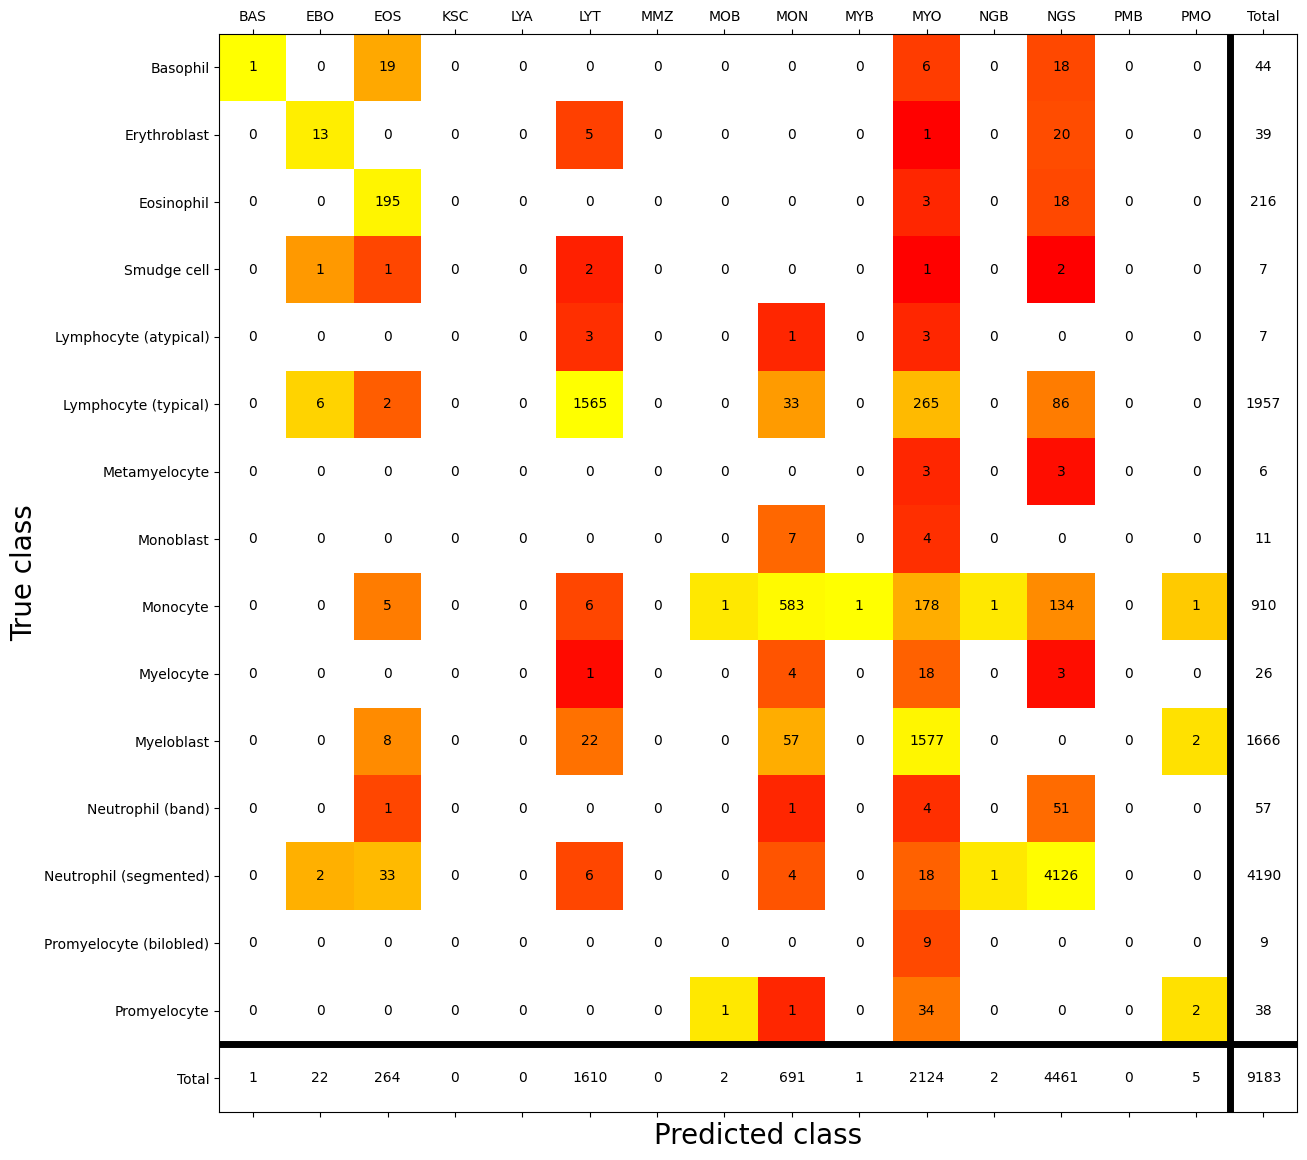

In [ ]:
import matplotlib
# from client.models.AMLmodel import classes as aml_classes

class_names_y = [classes[k] for k in classes] + ['Total']
class_names_x = [k for k in classes] + ['Total']

def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.autumn):

    f, ax = plt.subplots(1,1,figsize=(20,14))
    color_mat = np.zeros(matrix.shape)
    color_mat[:15,:15] = matrix[:15,:15]/np.maximum(1,np.sum(matrix[:15,:15],0))
    ax.matshow(color_mat, cmap=cmap, norm=matplotlib.colors.LogNorm())

    tick_mark = np.arange(16)
    ax.set_xticks(tick_mark)
    ax.set_yticks(tick_mark)
    ax.set_xticklabels(class_names_x)
    ax.set_yticklabels(class_names_y)

    for (i, j), z in np.ndenumerate(matrix):
        ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center')

    ax.axvline(x=14.5,color='black',lw=5)
    ax.axhline(y=14.5,color='black', lw=5)
    ax.set_xlabel('Predicted class', fontsize=20)
    ax.set_ylabel('True class', fontsize=20)

M = confusion_matrix(model, test_gen)
plot_confusion_matrix(M)
plt.savefig('confusion_sample.png')

## Create a model object in STACKn

In [ ]:
## We here create a model object in STACKn for use with Tensorflow Serving
# from stackn import stackn
# tf.saved_model.save(model, 'models/1/')
# !tar -czvf clinic1.tar.gz models
# stackn.create_object('clinic1', model_file='clinic1.tar.gz', release_type="major")

INFO:tensorflow:Assets written to: models/1/assets


10/13/2021 11:29:14 AM [builder_impl.py:774] Assets written to: models/1/assets


models/
models/1/
models/1/variables/
models/1/variables/variables.data-00000-of-00001
models/1/variables/variables.index
models/1/saved_model.pb
models/1/assets/
Released model: clinic1, release_type: major


True

In [ ]:
# import stackn.auth as sa
# import requests
# import numpy as np

# # If you are running locally with self signed certificate, then CHANGE the secure and verify variables to False
# secure = {"STACKN_SECURE": True}
# conf, status = sa.get_token(secure)

# # Load image to predict on / form input
# imgtest = np.load('/content/drive/MyDrive/digital-pathology-tutorial-master/dataset/processed/data_partitions/partition0/data_singlets/MON_1683.npy')
# imgtest=np.expand_dims(imgtest,0)
# inp = {"inputs": imgtest.tolist()}

# endpoint = 'https://r5c50cce0.studio.scaleoutsystems.com/v1/models/models:predict'
# res = requests.post(endpoint, json=inp, headers={"Authorization": "Bearer "+conf['STACKN_ACCESS_TOKEN']})

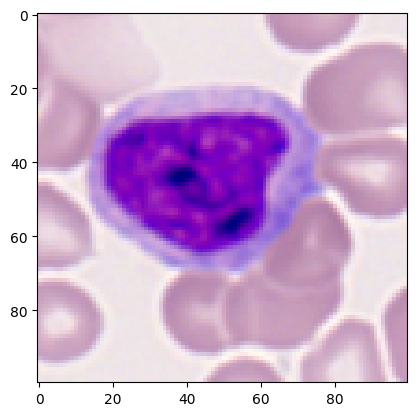

In [ ]:
import numpy as np
imgtest = np.load('/content/drive/MyDrive/digital-pathology-tutorial-master/dataset/processed/data_partitions/partition0/data_singlets/MON_1683.npy')
imgtest=np.expand_dims(imgtest,0)
inp = {"inputs": imgtest.tolist()}
plt.imshow(imgtest[0]);
# print("Prediction:", class_names_y[np.argmax(res.json()['outputs'])])

## Save weights for use as an initial model in FEDn

In [ ]:
import sys
print(sys.path)


['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython']


In [ ]:
import sys
sys.path.append('/root/.local/bin')
!pip show fedn


Name: fedn
Version: 0.11.1
Summary: Scaleout Federated Learning
Home-page: https://www.scaleoutsystems.com
Author: 
Author-email: Scaleout Systems AB <contact@scaleoutsystems.com>
License: Apache License
                                   Version 2.0, January 2004
                                http://www.apache.org/licenses/
        
           TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION
        
           1. Definitions.
        
              "License" shall mean the terms and conditions for use, reproduction,
              and distribution as defined by Sections 1 through 9 of this document.
        
              "Licensor" shall mean the copyright owner or entity authorized by
              the copyright owner that is granting the License.
        
              "Legal Entity" shall mean the union of the acting entity and all
              other entities that control, are controlled by, or are under common
              control with that entity. For the purpose

In [ ]:
!pip uninstall fedn
!pip install --user fedn

Found existing installation: fedn 0.11.1
Uninstalling fedn-0.11.1:
  Would remove:
    /root/.local/bin/fedn
    /root/.local/lib/python3.10/site-packages/fedn-0.11.1.dist-info/*
    /root/.local/lib/python3.10/site-packages/fedn/*
Proceed (Y/n)? Y
  Successfully uninstalled fedn-0.11.1
  Using cached fedn-0.11.1-py3-none-any.whl.metadata (20 kB)
Using cached fedn-0.11.1-py3-none-any.whl (170 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
# # !pip install --user fedn
# from fedn.utils.kerashelper import KerasHelper
# helper = KerasHelper()
# weights = model.get_weights()
# helper.save_model(weights, "weights_single_clinic.npz")

In [ ]:


model.save_weights('weights_single_clinic.weights.h5')
